In [1]:
!mkdir levels

In [1]:
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import random
import importlib
import game
import matplotlib.pyplot as plt
importlib.reload(game)

<module 'game' from '/content/game.py'>

In [2]:
class ValueNetwork(nn.Module):
    def __init__(self, input_size=5, output_size=1):
        super(ValueNetwork, self).__init__()
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 512)
        self.linear3 = nn.Linear(512, 512)
        self.linear4 = nn.Linear(512, output_size)

    def forward(self, state):
        state = self.linear1(state)
        state = self.linear2(state)
        state = self.linear3(state)
        state = self.linear4(state)
        return state


In [3]:
class BackwardAgent():
    def __init__(self):
        self.value_network = ValueNetwork()
        self.optimizer = optim.SGD(self.value_network.parameters(), lr=0.01)
        self.loss = nn.MSELoss()
        self.gamma = 0.9
        self.alpha = 0.1
        self.discount = 0.98
        self.eps = 0.1

    # POST: Returns backward trajectory as specified by the paper
    # More precisely returns a list of all board positions visited by the backward agent
    # and the packing order as impled by the backward trajectory
    def backward_trajectory(self, env):
        states = []
        packing_order = []
        state, reward, done = env.state(gamma=self.gamma)


    def policy(self, env):
        legal_moves = env.legal_moves()
        if len(legal_moves) == 0: # Agent is stuck angamma=Nond can't move
            return [None, None, None, None, None, None]

        value_moves = []
        for char in legal_moves:
            state, reward, done = env.step(char, gamma=self.gamma)
            state_tensor = torch.tensor(state)
            value_moves.append([char, state, state_tensor, self.value_network(state_tensor), reward, done])
        return max(value_moves, key=lambda x:x[3])

    def random_policy(self, env):
      legal_moves = env.legal_moves()
      if len(legal_moves)==0:
        return None
      else:
        return random.choice(legal_moves)

    def random_baseline(self, number_of_episodes, start, end):
      wins=[0 for i in range(number_of_episodes)]
      moves=[]
      for episode in tqdm(range(number_of_episodes)):
          # create new game instance
          ind = random.randint(start, end)
          env = game.ReverseGame(game.Game(level_id=ind), disable_prints=True)
          if episode % 100 == 0:
              moves.append(env.player_position)
          state, reward, done = env.state(gamma=self.gamma)
          while not done:
            action = self.random_policy(env)
            if episode % 100 == 0:
              moves.append(action)
            if action != None:
              state, reward, done = env.play(action, gamma=self.gamma)
              wins[episode] = wins[episode] + reward
            else:
              done = 1
      plt.plot([sum(wins[:i])/number_of_episodes for i in range(number_of_episodes)], label="random policy")
      plt.legend()
      print(f"in [{start}, {end}] random policy solved: {sum(wins)/number_of_episodes}, {sum(wins)}/{number_of_episodes}")


    def train(self, number_of_episodes, start, end):
        wins=[0 for i in range(number_of_episodes)]
        moves = []
        for episode in tqdm(range(number_of_episodes)):
            # create new game instance
            ind = random.randint(start, end)
            env = game.ReverseGame(game.Game(level_id=ind), disable_prints=True)
            if episode % 100 == 0:
                moves.append(env.player_position)
            state, reward, done = env.state(gamma=self.gamma)

            # do training on game instance
            while not done:
                # compute value of current state
                state_tensor = torch.tensor(state)
                value = self.value_network(state_tensor)

                # calculate next action according to policy
                [action, next_state, next_state_tensor, next_value, next_reward, next_done] = self.policy(env)
                if episode % 100 == 0:
                    moves.append(action)
                # print(f"reward from step: {next_reward}")

                if action is None: # agent is stuck, we are in the same state as before and use these to make the TD(0) updates
                    assert(next_value is None and next_done is None and next_reward is None and next_state_tensor is None and next_state is None)
                    next_value = value
                    next_state_tensor = state
                    next_done = 1
                    next_reward = reward


                # TD(0) update: V(s)←V(s)+α(R+γV(s')−V(s))
                target = value + self.alpha*(next_reward + self.gamma*next_value.detach()*(1-int(next_done)) - value) # using detach here to exclude prediction from computation graph as is standard in TD(0)

                # calculate loss
                loss = self.loss(value, target.detach())

                # optimize
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # make random move in environment
                if np.random.rand() < self.eps:
                    legal_moves = env.legal_moves()
                    if len(legal_moves) == 0:
                        break
                    else:
                        action = random.choice(legal_moves)
                        if episode % 100 == 0:
                            moves[-1] = action
                        state, reward, done = env.play(action, gamma=self.gamma)
                else:
                    state = next_state
                    done = next_done
                    reward = next_reward
                    if(action != None): # make the game step if there is a possible move, if there is no possible move, game will end
                        s, r, d = env.play(action, gamma=self.gamma)
                        if not (state == s and done == d and reward == r):
                            env.disable_prints=False
                            env.print_board()
                            print(env.turn)
                            print(f"print form top: {state}, {reward}, {done}")
                            print(f"print form bot: {s}, {r}, {d}")
                        assert(state == s and done == d and reward == r)
                wins[episode] = wins[episode] + reward

            # update learning rate
            self.alpha = self.alpha * self.discount
        plt.plot([sum(wins[:i])/number_of_episodes for i in range(number_of_episodes)], label="greedy policy")
        plt.legend()
        print(f"in[{start}, {end}] greedy policy solved: {sum(wins)/number_of_episodes}, {sum(wins)}/{number_of_episodes}")
        file_path = "run.json"
        json_data = json.dumps(moves)
        with open(file_path, "w") as file:
            file.write(json_data)

100%|██████████| 1000/1000 [00:19<00:00, 51.00it/s]


in [0, 0] random policy solved: 0.422, 422/1000


100%|██████████| 1000/1000 [00:42<00:00, 23.43it/s]


in[0, 0] greedy policy solved: 1.0, 1000/1000


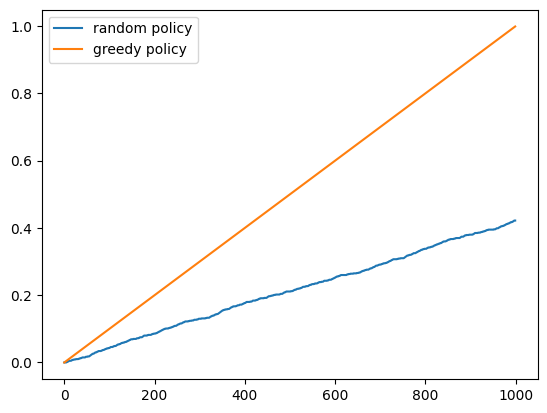

In [4]:
torch.manual_seed(40)
random.seed(40)
np.random.seed(40)
backwardagent = BackwardAgent()
backwardagent.random_baseline(number_of_episodes=1000, start=0, end=0)
backwardagent.train(number_of_episodes=1000, start=0, end=0)

100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


in[1, 1] greedy policy solved: 0.39, 39/100


100%|██████████| 100/100 [00:00<00:00, 107.89it/s]


in [1, 1] random policy solved: 0.41, 41/100


100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


in[1, 1] greedy policy solved: 0.38, 38/100


100%|██████████| 100/100 [00:00<00:00, 107.50it/s]


in [1, 1] random policy solved: 0.5, 50/100


100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


in[1, 1] greedy policy solved: 0.68, 68/100


100%|██████████| 100/100 [00:01<00:00, 73.39it/s]


in [1, 1] random policy solved: 0.44, 44/100


100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


in[1, 1] greedy policy solved: 0.39, 39/100


100%|██████████| 100/100 [00:00<00:00, 106.46it/s]


in [1, 1] random policy solved: 0.52, 52/100


100%|██████████| 100/100 [00:06<00:00, 14.44it/s]


in[1, 1] greedy policy solved: 0.92, 92/100


100%|██████████| 100/100 [00:01<00:00, 57.04it/s]


in [1, 1] random policy solved: 0.49, 49/100


100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


in[1, 1] greedy policy solved: 0.61, 61/100


100%|██████████| 100/100 [00:00<00:00, 121.95it/s]


in [1, 1] random policy solved: 0.55, 55/100


100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


in[1, 1] greedy policy solved: 0.92, 92/100


100%|██████████| 100/100 [00:01<00:00, 55.96it/s]


in [1, 1] random policy solved: 0.41, 41/100


100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


in[1, 1] greedy policy solved: 0.39, 39/100


100%|██████████| 100/100 [00:00<00:00, 106.97it/s]


in [1, 1] random policy solved: 0.53, 53/100


100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


in[1, 1] greedy policy solved: 0.5, 50/100


100%|██████████| 100/100 [00:01<00:00, 98.25it/s]


in [1, 1] random policy solved: 0.49, 49/100


100%|██████████| 100/100 [00:12<00:00,  7.71it/s]


in[1, 1] greedy policy solved: 0.71, 71/100


100%|██████████| 100/100 [00:00<00:00, 108.57it/s]


in [1, 1] random policy solved: 0.55, 55/100


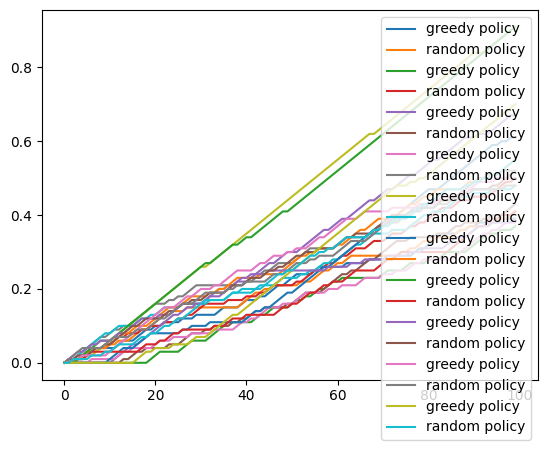

In [6]:
for i in range(10):
  backwardagent = BackwardAgent()
  backwardagent.train(number_of_episodes=100, start=1, end=1)
  backwardagent.random_baseline(number_of_episodes=100, start=1, end=1)